# Problem description

Another type of less traditional data is text.
There is potentially a lot of information about a company in documents such as
- News articles
- Annual/quarterly filings
- Analyst reports
- Blogs

The key element about text is that a document is a *sequence* of words.
In other words, order matters.
Consider
- "Machine Learning is easy not hard"
- "Machine Learning is hard not easy"

Two sentences with identical words but different meaning.

In this assignment we will analyze text in the form of Tweets.
Our objective is: given a tweet about a company, does the tweet indicate Positive sentiment or Negative sentiment.

This assignment will also serve as a preview of Natural Language Processing: the use of Machine Learning to analyze text.
This will be the subject of a later lecture.

Our immediate objective is to use Recurrent Neural Networks to analyze a sequence of words (i.e., a tweet).




## Goal: problem set 1

You will need to create Sequential models in Keras to analyze the sentiment in tweets.
- Each example is a sequence of words
- The labels are integers: high values indicate Positive sentiment, low values indicate Negative sentiment


## Learning objectives
- Learn how to use Recurrent Layer types as part of a Keras Sequential model
- Appreciate how layer choices impact number of weights

In [1]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.0.0
Version 2, minor 0


In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing

import os
import math

%matplotlib inline

In [4]:
import tensorflow as tf
import pandas as pd

import re

In [5]:
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, LSTM

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import plot_model
import IPython

# API for students

We will define some utility routines.

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

- getData: Get a collection of labelled images, used as follows

  >`data, labels = getData()`
- showData: Visualize labelled images, used as follows

  >`showData(data, labels)`

- train: train a model and visualize its progress, used as follows

  >`train(model, X_train, y_train, model_name, epochs=max_epochs)`


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

DATA_DIR = "./data"

tweet_file = "Apple-Twitter-Sentiment-DFE-1.csv"



"""
 Parameters:
- max_features: number of words in the vocabulary (and hence, the length of the One Hot Encoding feature vector)
- maxlen: number of words in a review
- embedding_dims: length of word vector
- filters: number of convolutional kernels.  These are "features" created by convolution.

"""

#
# set parameters:
max_features = 1000
maxlen = 40

batch_size = 32
embedding_dims = 50

hidden_dims = 250
epochs = 8

special = { "<PAD>": 0, 
           }

def getDataRaw():
    tweets_raw = pd.read_csv( os.path.join(DATA_DIR, tweet_file) )
    return tweets_raw

def getTextClean(tweets_raw):
    # Filter out rows with invalid sentiment
    mask = tweets_raw["sentiment"] == 'not_relevant'
    tweets_raw = tweets_raw[ ~ mask ]
    
    docs = tweets_raw["text"].apply(cleanTxt).values
    
    # We will treat the sentiment values as Categorical, rather than numeric
    le = sklearn.preprocessing.LabelEncoder(  )
    sents = le.fit_transform( tweets_raw[ "sentiment"] )
    
    return docs, sents

#
def cleanTxt(text):
 text = re.sub('@[A-Za-z0–9]+', '<MENTION>', text) #Removing @mentions
 text = re.sub('#', '', text) # Removing '#' hash tag
 text = re.sub('RT[\s]+', '<RT>', text) # Removing RT
 text = re.sub('https?:\/\/\S+', '<LINK>', text) # Removing hyperlink
 
 return text

def createOHE(max_features):
  mat = np.diag( np.ones(max_features))
  return mat

def show(tok, encoded_docs_padded):
    word_index = tok.word_index
    
    # Add the special characters to the word to index map
    for word, idx in special.items():
      word_index[word] = idx

    # Reverse map: index to word
    # Index_word: map index to word
    index_word = { idx:w for (w, idx) in word_index.items() }

    for i, rev in enumerate(encoded_docs_padded[0:5]):
      # Map each index in the example back to word
      rev_words = [ index_word[idx] for idx in rev if idx != 0]
      print("{i:d}:\t{r:s}".format(i=i,  r= " ".join(rev_words)) )
      # sent = y_train[i]
      # print("{i:d}:\t({sent:s})\t{r:s}".format(i=i, sent=sentiment[y_train[i]], r= " ".join(rev_words)) )
    
def getExamples(encoded_docs_padded, sents):
    OHE = createOHE(max_features)
    X = np.zeros( (encoded_docs_padded.shape[0], encoded_docs_padded.shape[1], max_features) )

    # Convert each word to a OHE representation
    for doc_num in range(0, encoded_docs_padded.shape[0]):
        encoded_doc = encoded_docs_padded[doc_num]
        ohe_encoded_doc = OHE[ encoded_doc ]

        X[doc_num] = ohe_encoded_doc

    y = sents
    
    return X, y

'\n Parameters:\n- max_features: number of words in the vocabulary (and hence, the length of the One Hot Encoding feature vector)\n- maxlen: number of words in a review\n- embedding_dims: length of word vector\n- filters: number of convolutional kernels.  These are "features" created by convolution.\n\n'

## Get the tweets (as text)

In [7]:
tweets_raw = getDataRaw()
tweets_raw[ ["text", "sentiment"] ].head(10)

print("Sentiment values (raw)", np.unique(tweets_raw["sentiment"]))

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,My cat only chews @apple cords. Such an #Apple...,3
3,I agree with @jimcramer that the #IndividualIn...,3
4,Nobody expects the Spanish Inquisition #AAPL,3
5,#AAPL:5 Rocket Stocks to Buy for December Gain...,3
6,Top 3 all @Apple #tablets. Damn right! http://...,5
7,CNBCTV: #Apple's margins better than expected?...,5
8,Apple Inc. Flash Crash: What You Need to Know ...,3
9,#AAPL:This Presentation Shows What Makes The W...,3


Sentiment values (raw) ['1' '3' '5' 'not_relevant']


## Data preprocessing

There will be a number of preprocessing steps necessary to convert the raw tweets to a form
amenable to a Neural Network.

The next few cells will take you through the journey from "raw" data to the X (array of examples)
and y (array of labels for each example) arrays that you will need for your Neural Network.

In an academic setting you will often be given X and y.
This will rarely be the case in the real world.

So although this journey has little to do with our objective in learning about Recurrent Neural Networks,
we encourage you to follow along.

If you are anxious to get to the Recurrent Neural Network part: you can defer the journey until later
and skip to the cell that defines X and y.

As you can see, tweets have their own special notation that distinguishes it from ordinary language
- "Mentions" begin with "@" and refer to another user: "@kenperry"
- "Hash tags" begin witn "#" and refer to a subject: #MachineLearning

This means that our vocabulary (set of distinct words) can be huge.  To manage the vocabulary size
and simplify the problem (perhaps losing information on the way), we will **not** distinguish between
individual mentions and hash tags

Let's also examine the possible sentiment values
- There is a "not_relevant" value; we should eliminate these examples
- The sentiment value is a string
- The strings represent non-consecutive integers

There is quite a bit of cleaning of the raw data necessary; fortunately, we will do that for you below.

In [8]:
docs, sents = getTextClean(tweets_raw)

print("Docs shape is ", docs.shape)
print("Sents shape is ", sents.shape)

docs[:5]
print("Possible sentiment values: ",  np.unique(sents) ) 


Docs shape is  (3804,)
Sents shape is  (3804,)


array(['AAPL:The 10 best Steve Jobs emails ever...<LINK>',
       '<RT><MENTION>: Why AAPL Stock Had a Mini-Flash Crash Today $AAPL aapl\n<LINK>',
       'My cat only chews <MENTION> cords. Such an AppleSnob.',
       "I agree with <MENTION> that the IndividualInvestor should own not trade Apple AAPL, it's extended so today's pullback is good to see",
       'Nobody expects the Spanish Inquisition AAPL'], dtype=object)

Possible sentiment values:  [0 1 2]


## More data preprocessing

Great, our text is in much better shape and our sentiment (target value for prediction) are now consecutive values.

But computers handle numbers much more readily than strings.
We will need to convert the text in a *sequence* of numbers
- Break text up into words
- Assign each word a distinct integer

Moreover, it will be easier if all sequences have the same length.
We can add a "padding" character to the front if necessary.

Again, we do this for you below.

In [9]:
tok = Tokenizer(num_words=max_features)
tok.fit_on_texts(docs)

encoded_docs = tok.texts_to_sequences(docs)
encoded_docs_padded = sequence.pad_sequences(encoded_docs, maxlen=maxlen)

encoded_docs_padded[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   4,   3, 204, 136,  93, 109, 356, 253,
          2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          8,   1,  43,   4, 123, 141,  11, 230, 537, 454, 168,   4,   4,
          2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  15, 182,   1, 805, 581,
         60],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  13,  48,  36,   1,
         40,   3, 156, 212,  49, 153,   6,   4,  85,  55,   7, 157,   5,
        231],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 

## Verify that our encoded documents are the same as the cleaned original

At this point: convince yourself that all we have done was encode words as integers and pad out all text to the same length.  The following will demonstrate this

In [10]:
show(tok, encoded_docs_padded)

0:	aapl the 10 best steve jobs emails ever link
1:	rt mention why aapl stock had a mini flash crash today aapl aapl link
2:	my only mention cords such an
3:	i agree with mention that the should own not trade apple aapl it's so is good to see
4:	the aapl


## Even more preprocessing

Although a word has been encoded as an integer, this integer doesn't have a particular meaning.

We will therefore convert each word to a One Hot Encoded (OHE) vector
- The length of the vector is equal to the length of the vocabulary (set of distinct words)
- The vector is all 0 except for a single location which will be 1
- If the word is the $k^{th}$ word of the vocabulary, the position of the sole 1 will be $k$

This representation is called One Hot Encoding
- A word as a feature vector of length $V$, where $V$ is the number of words in the vocabulary
    - Feature $j$ is a binary indicator which is true if the word is the $j^{th}$ word in the vocabulary
    
Finally: we can get the set of examples and associated labels in a form ready for processing by
the Neural Network.

At this point, they will be hard to recognize by a human being.

In [11]:
X, y = getExamples(encoded_docs_padded, sents)
X[:5]

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

## A note on the representation of words as OHE vectors

There are *much better* representations of words than as OHE vectors !

We will learn about this in our lecture on Natural Languag Processing.

For now, the OHE representation will suffice.

# Split the data into test and training sets


In [12]:
 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# How long is the sequence in a *single* example

In [13]:
# Set two variables
# example_sequence_len: length of the sequence
# example_num_features: number of features in a single element of the sequence (of a single example)

### BEGIN SOLUTION

example_shape = X.shape[1:]
example_sequence_len, example_num_features = example_shape[0], example_shape[1]
### END SOLUTION

In [14]:
assert example_sequence_len == maxlen
assert example_num_features == max_features

# Utility functions

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile

def plot_training(history, metric="acc"):
  """
  Plot training and validation statistics
  - accuracy vs epoch number
  - loss     vs epoch number
  
  From https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
  """  
  
  # Accuracy
  acc = history.history[metric]
  val_acc = history.history['val_' + metric]
  
  # Loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training ' + metric)
  plt.plot(epochs, val_acc, 'r', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [16]:
def trainModel(model, X, y, num_epochs=20, metric="acc"):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)
    model.compile(loss='mse',
                metrics=['mse']
                )
    
    es_callback = EarlyStopping(monitor='val_loss', min_delta=.005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    callbacks = [ #es_callback,
            # ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
            ] 
   
    history = model.fit(X_train, y_train,
        epochs=num_epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks)

    return history

def trainModelCat(model, X, y, num_epochs=20, metric="acc"):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)
    model.compile(loss='sparse_categorical_crossentropy',
                metrics=[metric]
                )
    
    es_callback = EarlyStopping(monitor='val_loss', min_delta=.005, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    callbacks = [ es_callback,
            # ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
            ] 
   
    history = model.fit(X_train, y_train,
        epochs=num_epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks)

    return history


# Part 1: Create a Keras Sequential model using a Recurrent layer type

You will create a model that
- takes as input: a sequence of one hot encodings of words (i.e., a representation of a tweet)
- predicts (outputs) a sentiment

**Note**
You should treat the sentiment as a Categorical (discrete) value, rather than a continous one
- As we saw: the sentiment label values are not continuous
- We cannot really assign a "magnitude" to the sentiment
    - We cannot say that a sentiment of 5 is five times "higher" than a sentiment of 1
- We will thus treat the problem as one of Classification rather than Regression


This will be a very basic model with two layers
- A Recurrent layer (LSTM to be specific) with a hidden state size of 128
- A Head layer implementing multinomial Classification


**Hints**
- We have not one hot encoded the labels (i.e., the sents variable)
    - You may wish to do so
    - Alternatively: understand the difference between the Keras 'categorical_crossentropy' and 'sparse_categorical_crossentropy' loss functions

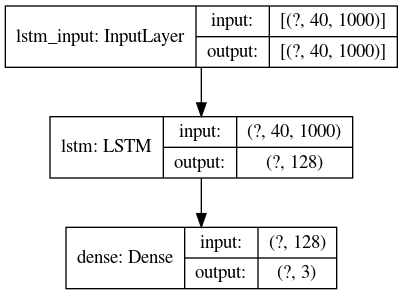

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               578048    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 578,435
Trainable params: 578,435
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_lstm = Sequential( [ LSTM(128, input_shape=X_train.shape[-2:]),
                          Dense( len( np.unique(y) ), activation="softmax")
                         ]
                       )

plot_lstm = plotModel(model_lstm, "lstm")
IPython.display.Image(plot_lstm) 

model_lstm.summary()

In [18]:
history_lstm = trainModelCat( model_lstm, X_train, y_train )

Train on 3080 samples, validate on 343 samples
Epoch 1/20
3080/3080 [==============================] - 10s 3ms/sample - loss: 0.8789 - acc: 0.6218 - val_loss: 0.7373 - val_acc: 0.7172
Epoch 2/20
3080/3080 [==============================] - 7s 2ms/sample - loss: 0.7063 - acc: 0.7263 - val_loss: 0.7198 - val_acc: 0.6880
Epoch 3/20
3080/3080 [==============================] - 7s 2ms/sample - loss: 0.6390 - acc: 0.7500 - val_loss: 0.6644 - val_acc: 0.7638
Epoch 4/20
3080/3080 [==============================] - 7s 2ms/sample - loss: 0.5662 - acc: 0.7727 - val_loss: 0.6621 - val_acc: 0.7026
Epoch 5/20
3080/3080 [==============================] - 7s 2ms/sample - loss: 0.5148 - acc: 0.7964 - val_loss: 0.9207 - val_acc: 0.6910
Epoch 6/20
3080/3080 [==============================] - 7s 2ms/sample - loss: 0.4888 - acc: 0.8169 - val_loss: 0.7017 - val_acc: 0.7551


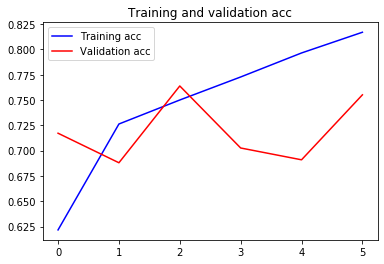

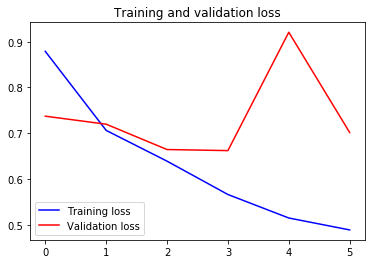

In [19]:
plot_training(history_lstm)

## How many weights in your recurrent model?

How many weights in your model ?

You should always be sensitive to how "big" your model is.

In [20]:
# Set variable
# - num_weights_lstm: number of weights in your model

### BEGIN SOLUTION
num_weights_lstm = model_lstm.count_params()
### END SOLUTION

# Part 2: Create a model consider only of a Classification head

The Recurrent layer type creates a fixed length (i.e., size of hidden state) encoding of a variable length input sequence
- No matter how long the input, the encoding will have fixed length

But it need quite a few parameters.

Let's compare this to a simple Classifier only model
- That reduces the sequence to a single feature vector
    - Length of the single feature vector is the same as any element of the sequence
- There are a couple of ways to do this
    - Take the sum or average (across the sequence) of each feature
    - Take the max (across the sequence) of each feature

Create a Keras Sequential model that
- Reduces the sequence to a singleton with the same number of features
- Classifies directly on this singleton

**Hints**
- Investigate the Keras `GlobalMaxPooling1D` and `GlobalAveragePooling1D` layer types

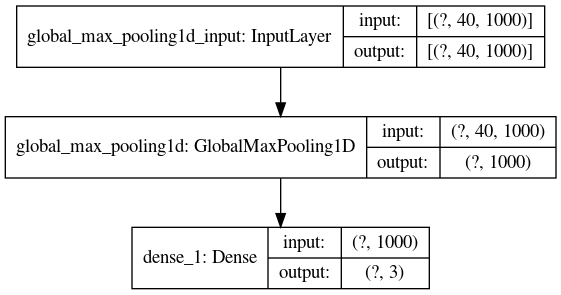

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_max_pooling1d (Global (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3003      
Total params: 3,003
Trainable params: 3,003
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_simple = Sequential( [ GlobalMaxPooling1D(input_shape=X_train.shape[-2:]),
                             Dense( len( np.unique(y) ), activation="softmax")
                           ]
                         )

plot_simple = plotModel(model_simple, "simple")
IPython.display.Image(plot_simple) 

model_simple.summary()

In [22]:
history_simple = trainModelCat( model_simple, X_train, y_train )

Train on 3080 samples, validate on 343 samples
Epoch 1/20
3080/3080 [==============================] - 11s 3ms/sample - loss: 0.9505 - acc: 0.5968 - val_loss: 0.8283 - val_acc: 0.6793
Epoch 2/20
3080/3080 [==============================] - 1s 164us/sample - loss: 0.8033 - acc: 0.6945 - val_loss: 0.7457 - val_acc: 0.7143
Epoch 3/20
3080/3080 [==============================] - 0s 132us/sample - loss: 0.7423 - acc: 0.7172 - val_loss: 0.7062 - val_acc: 0.7376
Epoch 4/20
3080/3080 [==============================] - 0s 129us/sample - loss: 0.7053 - acc: 0.7227 - val_loss: 0.6821 - val_acc: 0.7464
Epoch 5/20
3080/3080 [==============================] - 0s 135us/sample - loss: 0.6777 - acc: 0.7338 - val_loss: 0.6652 - val_acc: 0.7493
Epoch 6/20
3080/3080 [==============================] - 0s 128us/sample - loss: 0.6554 - acc: 0.7390 - val_loss: 0.6516 - val_acc: 0.7493
Epoch 7/20
3080/3080 [==============================] - 0s 132us/sample - loss: 0.6371 - acc: 0.7448 - val_loss: 0.6421 - val_

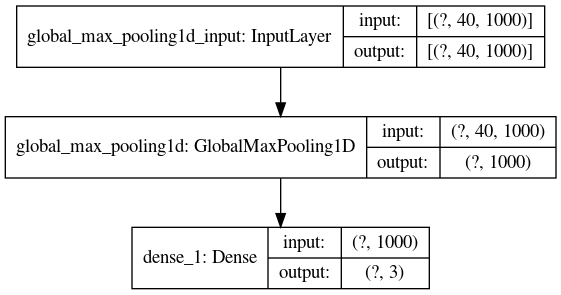

In [23]:
plot_simple = plotModel(model_simple, "simple")
IPython.display.Image(plot_simple) 

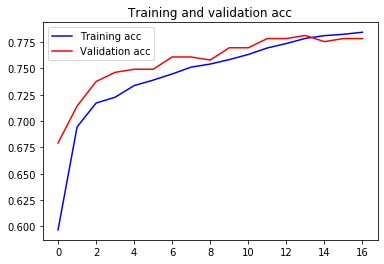

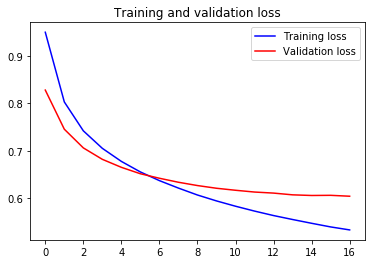

In [24]:
plot_training(history_simple)

## How many weights in your Classifier only model ?

How many weights in your model ?

You should always be sensitive to how "big" your model is.

In [25]:
# Set variable
# - num_weights_lstm: number of weights in your model

### BEGIN SOLUTION
num_weights_simple = model_simple.count_params()
### END SOLUTION

# Discussion

- Was the increase in number of weights compensated by a gain in accuracy when using a Recurrent Layer type compared to the Classifier only model ?
- Can you speculate why this is so ?